<a href="https://colab.research.google.com/github/Mohand995/Unet_From_Scratch/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import keras 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np 
import os

In [42]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [43]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='~/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=Fa

In [44]:
def resize(image,mask):
  image=tf.image.resize(image,(128,128),method='nearest')
  mask=tf.image.resize(mask,(128,128),method='nearest')
  return image,mask

In [45]:
def augment(image,mask):
  if tf.random.uniform(())>0.5:
    image=tf.image.flip_left_right(image)
    mask=tf.image.flip_left_right(mask)
  return image,mask
                                  


In [46]:
def normalize(image,mask):
  image=tf.cast(image,tf.float32)/255
  mask=mask-1
  return image,mask

In [47]:
def load_train(datapoint):
  image=datapoint['image']
  mask=datapoint['segmentation_mask']
  image,mask=resize(image,mask)
  image,mask=augment(image,mask)
  image,mask=normalize(image,mask)
  return image,mask

In [48]:
def load_test(datapoint):
  image=datapoint['image']
  mask=datapoint["segmentation_mask"]
  image,mask=resize(image,mask)
  image,mask=normalize(image,mask)
  return image,mask

In [49]:
train_ds=dataset['train'].map(load_train,num_parallel_calls=tf.data.AUTOTUNE)
test_ds=dataset['test'].map(load_test,num_parallel_calls=tf.data.AUTOTUNE)

In [50]:
image,mask=train_ds.as_numpy_iterator().next()

In [51]:
print(image.shape)
print(mask.shape)

(128, 128, 3)
(128, 128, 1)


In [53]:
batch_siz=64
buffer_size=1000

train_ds=train_ds.cache().shuffle(buffer_size).batch(batch_siz).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set=test_ds.take(3000).batch(64)
test_set=test_ds.skip(3000).batch(64)

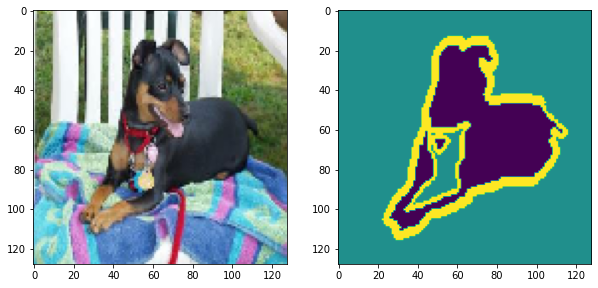

In [63]:
plt.figure(figsize=(10,10))
for image,mask in train_ds.take(1):
  first_img=image[0]
  first_mask=mask[0]
  plt.subplot(1,2,1)
  plt.imshow(tf.keras.utils.array_to_img(first_img))
  plt.subplot(1,2,2)
  plt.imshow(tf.keras.utils.array_to_img(first_mask))




**Model**

In [69]:
def double_conv_block(x,no_of_filters):
  x=tf.keras.layers.Conv2D(no_of_filters,3,padding='same',kernel_initializer="he_normal",activation='relu')(x)
  x=tf.keras.layers.Conv2D(no_of_filters,3,padding='same',kernel_initializer="he_normal",activation='relu')(x)
  return x



In [75]:
def downsample_block(x,no_of_filters):
  f=double_conv_block(x,no_of_filters)
  p=tf.keras.layers.MaxPool2D(2)(f)
  p=tf.keras.layers.Dropout(0.3)(p)
  return f,p

In [78]:
def upsample_block(x, conv_features, n_filters):
   x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = tf.keras.layers.concatenate([x, conv_features])
   x = tf.keras.layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [67]:
def build_unet():

   inputs = tf.keras.layers.Input(shape=(128,128,3))
  
   f1, p1 = downsample_block(inputs, 64)
   
   f2, p2 = downsample_block(p1, 128)
   
   f3, p3 = downsample_block(p2, 256)

   f4, p4 = downsample_block(p3, 512)
  
   bottleneck = double_conv_block(p4, 1024)
   
   u6 = upsample_block(bottleneck, f4, 512)
  
   u7 = upsample_block(u6, f3, 256)

   u8 = upsample_block(u7, f2, 128)
   
   u9 = upsample_block(u8, f1, 64)
  
   outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
  
  
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [79]:
Model=build_unet()

In [81]:
Model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [102]:
model_history = Model.fit(train_ds,
                              epochs=10,
                              validation_data=val_set)

Epoch 1/10
58/58 [==============================] - 75s 1s/step - loss: 0.4569 - accuracy: 0.8232 - val_loss: 0.4166 - val_accuracy: 0.8374
Epoch 2/10
58/58 [==============================] - 74s 1s/step - loss: 0.4226 - accuracy: 0.8367 - val_loss: 0.4606 - val_accuracy: 0.8165
Epoch 3/10
58/58 [==============================] - 75s 1s/step - loss: 0.4128 - accuracy: 0.8409 - val_loss: 0.3982 - val_accuracy: 0.8502
Epoch 4/10
58/58 [==============================] - 75s 1s/step - loss: 0.3854 - accuracy: 0.8518 - val_loss: 0.3616 - val_accuracy: 0.8615
Epoch 5/10
58/58 [==============================] - 75s 1s/step - loss: 0.3717 - accuracy: 0.8573 - val_loss: 0.3773 - val_accuracy: 0.8540
Epoch 6/10
58/58 [==============================] - 75s 1s/step - loss: 0.3522 - accuracy: 0.8654 - val_loss: 0.3906 - val_accuracy: 0.8521
Epoch 7/10
58/58 [==============================] - 74s 1s/step - loss: 0.3516 - accuracy: 0.8656 - val_loss: 0.3566 - val_accuracy: 0.8649
Epoch 8/10
58/58 [==

**Predictions**

In [103]:
for img,mask in test_set.take(1):
  random_index=np.random.choice(10)
  rand_img=img[random_index]
  rand_mask=mask[random_index]



In [104]:
def predict_img(rand_img):
    predicted_img=Model.predict(tf.expand_dims(rand_img,0))
    predicted_img=tf.squeeze(tf.argmax(predicted_img,-1))
    return predicted_img


In [105]:
predicted_mask=predict_img(rand_img)

1/1 [==============================] - 0s 19ms/step


Text(0.5, 1.0, 'predicted_mask')

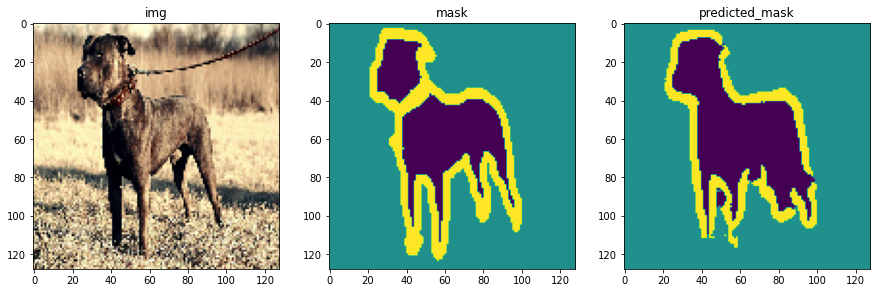

In [106]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(rand_img)
plt.title('img')
plt.subplot(1,3,2)
plt.imshow(tf.keras.utils.array_to_img(rand_mask))
plt.title('mask')
plt.subplot(1,3,3)
plt.imshow(predicted_mask)
plt.title("predicted_mask")

